In [1]:
import time
import re
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns

from selenium import webdriver
from selenium.common.exceptions import TimeoutException
from selenium.common.exceptions import NoSuchElementException
from selenium.webdriver.support.ui import WebDriverWait # available since 2.4.0
from selenium.webdriver.support import expected_conditions as EC # available since 2.26.0
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.by import By
from sklearn.preprocessing import StandardScaler

from secrets import *

In [2]:
email = AUTH["email"]
password = AUTH["password"]

## LOGIN

In [3]:
# https://stackoverflow.com/questions/33326459/logging-into-espn-using-selenium

In [4]:
driver = webdriver.Chrome()

In [5]:
driver.get("http://games.espn.go.com/ffl/signin")

In [6]:
w = WebDriverWait(driver,1000).until(EC.presence_of_all_elements_located((By.XPATH,"(//iframe)")))

In [7]:
driver.switch_to_frame("disneyid-iframe")
time.sleep(2)

/Users/codyschank/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: use driver.switch_to.frame instead
  """Entry point for launching an IPython kernel.


In [8]:
driver.find_element_by_css_selector('input[type=email]').send_keys(email)

In [9]:
driver.find_element_by_css_selector('input[type=password]').send_keys(password)

In [10]:
driver.find_element_by_xpath("//button").click()

## STATS

In [130]:
leagueID = "84057"
url = "http://fantasy.espn.com/basketball/players/add?leagueId="+leagueID+"&view=stats"
url

'http://fantasy.espn.com/basketball/players/add?leagueId=84057&view=stats'

In [131]:
driver.get(url)

In [132]:
# show all players
driver.find_element_by_xpath("//*[@id='filterStatus']/option[1]").click()

In [133]:
# do I want totals or averages?
# check what I used in original scraping
# make sure to change in loop too

In [134]:
# show totals
# driver.find_element_by_xpath("//*[@id='espn-analytics']/div/div[5]/div[2]/div[2]/div/div/div[1]/div/div[3]/label[1]/div").click()
# show averages
driver.find_element_by_xpath("//*[@id='espn-analytics']/div/div[5]/div[2]/div[2]/div/div/div[1]/div/div[3]/label[2]/div").click()

In [135]:
xpath = '//*[@id="espn-analytics"]/div/div[5]/div[2]/div[2]/div/div/div[2]/section/table/tbody'
table = driver.find_element_by_xpath(xpath)

In [136]:
cells = table.text.split('\n')

In [87]:
nba_teams = ['Hou','Mil','No','GS','LAL','OKC','Phi','Min','Por','Ind','Tor','Den','Bos','SA','Wsh','Utah','Cle','Det',
            'Cha','Phx','Dal','Mem','LAC','Mia','Atl','NY','Orl','Chi','Sac','Bkn']

In [137]:
# clean out unnecessary/ complicating data
cells = [i for i in cells if i not in ['O','DTD']]
#cells = [i for i in cells if i not in nba_teams]
cells = [i for i in cells if '@' not in i]
cells = [i for i in cells if ':' not in i]
players = cells[6:cells.index('STATS RESEARCH')]
stats = cells[(cells.index('+/-')+1):] # find '+/-', and start from the cell after that?

In [138]:
players = [i for i in players if '--' not in i]

In [139]:
# integrate teams into the dataframe, if I can, will help with schedule
players

['Anthony Davis',
 'No',
 'PF, C',
 'DOIS',
 'Joel Embiid',
 'Phi',
 'C',
 'Wood',
 'James Harden',
 'Hou',
 'SG, PG',
 'Wood',
 'LeBron James',
 'LAL',
 'SF, PF',
 'BEB',
 'Kevin Durant',
 'GS',
 'SF, PF',
 'Brog',
 'Russell Westbrook',
 'OKC',
 'PG',
 'PREZ',
 'Damian Lillard',
 'Por',
 'PG',
 'Brog',
 'Min',
 'Stephen Curry',
 'GS',
 'PG',
 'gov',
 'Paul George',
 'OKC',
 'SF',
 'BXV',
 'Giannis Antetokounmpo',
 'Mil',
 'PF, SF',
 'DEKK',
 'Karl-Anthony Towns',
 'Min',
 'C',
 'WILL',
 'Kemba Walker',
 'Cha',
 'PG',
 'WILL',
 'Kawhi Leonard',
 'Tor',
 'SF',
 'YOC',
 'Nikola Jokic',
 'Den',
 'C',
 'DEKK',
 'Ben Simmons',
 'Phi',
 'PG, SF',
 'Wood',
 'DeMar DeRozan',
 'SA',
 'SG, SF',
 'gov',
 'Jimmy Butler',
 'Phi',
 'SG, SF',
 'ROOK',
 'Kyrie Irving',
 'Bos',
 'PG',
 'BEB',
 'Andre Drummond',
 'Det',
 'C',
 'Brog',
 'Kyle Lowry',
 'Tor',
 'PG',
 'YOC',
 'Blake Griffin',
 'Det',
 'PF',
 'DOIS',
 'LaMarcus Aldridge',
 'SA',
 'PF, C',
 'Brog',
 'Bradley Beal',
 'Wsh',
 'SG',
 'PREZ',
 '

In [90]:
columns = ['player','position','fantasy_team','minutes','fgm/fga','fg%','ftm/fta','ft%','3pm','reb','ast','stl','blk','pts','pr5','own','change']
statsTable = pd.DataFrame()

In [91]:
j = 0
k = 0
for i in range(50):
    player = players[j:j+3]
    j = j+3
    player_stats = stats[k:k+14]
    k = k+14
    values = player+player_stats
    row = dict(zip(columns, values))
    statsTable = statsTable.append(row, ignore_index=True)

In [93]:
#statsTable.head(50)

In [66]:
# this is another way to do it, with less cleanging post scraprin, but hits that page many more times, and thus flags the account
'''for i in range(1,51):
    xpath = '//*[@id="espn-analytics"]/div/div[5]/div[2]/div[2]/div/div/div[2]/section/table/tbody/tr/td[1]/table/tbody/tr[' + str(i) + ']/td[1]'
    playername = driver.find_element_by_xpath(xpath)
    playername = playername.text.split('\n')
    playername = [j for j in playername if j not in ['O','DTD']]
    xpath = '//*[@id="espn-analytics"]/div/div[5]/div[2]/div[2]/div/div/div[2]/section/table/tbody/tr/td[1]/table/tbody/tr[' + str(i) + ']/td[2]'
    fantasyteam = driver.find_element_by_xpath(xpath)
    fantasyteam = fantasyteam.text.split('\n')
    xpath = '//*[@id="espn-analytics"]/div/div[5]/div[2]/div[2]/div/div/div[2]/section/table/tbody/tr/td[2]/div/div/div[2]/table/tbody/tr/td/table/tbody/tr[' + str(i) + ']'
    stats = driver.find_element_by_xpath(xpath)
    stats = stats.text.split('\n')
    values = playername+fantasyteam+stats
    row = dict(zip(columns, values))
    statsTable = statsTable.append(row, ignore_index=True)
''' and None

In [94]:
for i in range(2,6):
    next_page = "//*[@id='espn-analytics']/div/div[5]/div[2]/div[2]/div/div/div[2]/div/div/ul/li["+str(i)+"]"
    driver.find_element_by_xpath(next_page).click()
    time.sleep(4)
    xpath = '//*[@id="espn-analytics"]/div/div[5]/div[2]/div[2]/div/div/div[2]/section/table/tbody'
    table = driver.find_element_by_xpath(xpath)
    cells = table.text.split('\n')
    cells = [i for i in cells if i not in ['O','DTD']]
    cells = [i for i in cells if i not in nba_teams]
    cells = [i for i in cells if '@' not in i]
    cells = [i for i in cells if ':' not in i]
    players = cells[6:cells.index('STATS RESEARCH')]
    players = [i for i in players if '--' not in i]
    stats = cells[(cells.index('+/-')+1):] 
    j = 0
    k = 0
    for i in range(50):
        player = players[j:j+3]
        j = j+3
        player_stats = stats[k:k+14]
        k = k+14
        values = player+player_stats
        row = dict(zip(columns, values))
        statsTable = statsTable.append(row, ignore_index=True)

In [95]:
statsTable.shape

(250, 17)

In [97]:
#statsTable.tail(50)

## ANALYZE

In [98]:
statsTable['fta'] = statsTable['ftm/fta'].str.split('/',expand=True)[1]
statsTable['fga'] = statsTable['fgm/fga'].str.split('/',expand=True)[1]
statsTable = statsTable.drop(columns = ['pr5','own','change','ftm/fta','fgm/fga'])

In [99]:
statsTable = statsTable.replace("--","0")

In [100]:
statsTable['ast'] = pd.to_numeric(statsTable['ast']) 
statsTable['blk'] = pd.to_numeric(statsTable['blk']) 
statsTable['reb'] = pd.to_numeric(statsTable['reb']) 
statsTable['pts'] = pd.to_numeric(statsTable['pts']) 
statsTable['stl'] = pd.to_numeric(statsTable['stl'])
statsTable['3pm'] = pd.to_numeric(statsTable['3pm'])
statsTable['ft%'] = pd.to_numeric(statsTable['ft%'])
statsTable['fg%'] = pd.to_numeric(statsTable['fg%'])
statsTable['fta'] = pd.to_numeric(statsTable['fta'])
statsTable['fga'] = pd.to_numeric(statsTable['fga'])
statsTable['minutes'] = pd.to_numeric(statsTable['minutes'])

In [101]:
scaler = StandardScaler()

In [102]:
statsTable[['ast', 'blk','reb','pts','stl','3pm','ft%','fg%','fta','fga']] = scaler.fit_transform(statsTable[['ast', 'blk','reb','pts','stl','3pm','ft%','fg%','fta','fga']])

In [103]:
statsTable.head()

,3pm,ast,blk,fantasy_team,fg%,ft%,minutes,player,position,pts,reb,stl,fta,fga
0,-0.280034,1.081334,4.542445,DOIS,0.501711,0.468958,37.3,Anthony Davis,"PF, C",2.438952,2.600549,1.819743,3.201486,2.003465
1,0.048644,0.443639,2.793557,Wood,0.136516,0.341789,34.3,Joel Embiid,C,2.202729,2.875028,-0.697191,3.881362,1.816473
2,3.116304,2.749151,0.073065,Wood,-0.054381,0.517868,36.1,James Harden,"SG, PG",2.753915,0.233170,2.658721,3.619871,2.169679
3,1.144237,2.013350,0.461706,BEB,0.634509,-0.064171,34.9,LeBron James,"SF, PF",2.580685,0.919367,0.980765,2.678504,2.128125
4,0.486881,1.768082,1.044669,Brog,0.543210,1.016760,35.9,Kevin Durant,"SF, PF",2.643678,0.987986,0.141787,2.678504,2.086572


In [104]:
statsTable['fga_adj'] = statsTable['fga'] + abs(statsTable['fga'].min())
statsTable['fta_adj'] = statsTable['fta'] + abs(statsTable['fta'].min())

In [105]:
statsTable['fg%_adj'] = statsTable['fg%'] * statsTable['fga_adj']
statsTable['ft%_adj'] = statsTable['ft%'] * statsTable['fta_adj']

In [106]:
statsTable[['fg%_adj','ft%_adj']] = scaler.fit_transform(statsTable[['fg%_adj','ft%_adj']])

In [107]:
statsTable = statsTable.drop(columns = ['fga_adj','fta_adj','fg%','ft%','fta','fga'])

In [108]:
statsTable['cumulative'] = statsTable['ft%_adj'] + statsTable['fg%_adj'] + statsTable['ast'] + statsTable['blk'] + statsTable['pts'] + statsTable['reb'] + statsTable['stl'] + statsTable['3pm']  

In [109]:
statsTable = statsTable.sort_values('cumulative',ascending=False)

In [110]:
statsTable.head(20)

,3pm,ast,blk,fantasy_team,minutes,player,position,pts,reb,stl,fg%_adj,ft%_adj,cumulative
0,-0.280034,1.081334,4.542445,DOIS,37.3,Anthony Davis,"PF, C",2.438952,2.600549,1.819743,1.524649,2.060726,15.788364
2,3.116304,2.749151,0.073065,Wood,36.1,James Harden,"SG, PG",2.753915,0.233170,2.658721,-0.447749,2.553004,13.689580
4,0.486881,1.768082,1.044669,Brog,35.9,Kevin Durant,"SF, PF",2.643678,0.987986,0.141787,1.710619,4.277549,13.061253
7,4.540575,1.522815,-0.509898,gov,33.4,Stephen Curry,PG,2.722419,0.061620,0.561276,1.729897,2.420744,13.049449
9,-0.937389,1.620922,1.433311,DEKK,33.7,Giannis Antetokounmpo,"PF, SF",2.281470,2.772098,1.400254,3.230913,-1.091329,10.710249
12,0.815559,0.149319,0.073065,YOC,34.6,Kawhi Leonard,SF,2.218477,1.159535,2.239232,1.022094,2.346953,10.024234
8,2.239830,0.836067,0.461706,BXV,34.9,Paul George,SF,1.840521,1.056606,2.868465,-0.912397,1.180610,9.571408
10,0.815559,-0.194055,2.210594,WILL,33.7,Karl-Anthony Towns,C,1.415320,2.429000,0.351532,0.818314,1.712702,9.558966
1,0.048644,0.443639,2.793557,Wood,34.3,Joel Embiid,C,2.202729,2.875028,-0.697191,0.212260,1.667494,9.546161
3,1.144237,2.013350,0.461706,BEB,34.9,LeBron James,"SF, PF",2.580685,0.919367,0.980765,2.062758,-0.635993,9.526876


## My team

In [111]:
my_team = statsTable.loc[statsTable.fantasy_team == 'Brog']
my_team = my_team.loc[my_team['minutes'] > 0]
my_team.shape

(14, 13)

In [112]:
my_team

,3pm,ast,blk,fantasy_team,minutes,player,position,pts,reb,stl,fg%_adj,ft%_adj,cumulative
4,0.486881,1.768082,1.044669,Brog,35.9,Kevin Durant,"SF, PF",2.643678,0.987986,0.141787,1.710619,4.277549,13.061253
6,1.911152,1.817136,-0.121256,Brog,35.2,Damian Lillard,PG,2.344463,0.061620,-0.067957,-0.324502,3.365554,8.986209
18,-1.156508,-0.684590,2.210594,Brog,32.8,Andre Drummond,C,0.911378,3.561224,1.190510,1.183297,-3.624365,3.591541
142,2.020711,-0.095949,-0.121256,Brog,35.5,Justin Holiday,"SG, SF",0.076725,-0.075619,2.029487,-0.642774,0.050467,3.241793
86,0.706000,-0.684590,0.461706,Brog,30.0,T.J. Warren,"SF, PF",0.848386,-0.281478,0.351532,1.070949,0.581202,3.053707
97,1.472915,-0.046895,-0.121256,Brog,30.8,Buddy Hield,SG,1.005868,0.198860,-0.697191,0.484100,0.438818,2.735219
21,-1.266067,-0.194055,1.238990,Brog,33.4,LaMarcus Aldridge,"PF, C",0.911378,1.742803,-0.906935,-0.142750,1.208145,2.591508
106,0.706000,0.345532,-0.704219,Brog,30.2,Malcolm Brogdon,"SG, PG",0.470430,-0.144239,-0.697191,0.983225,0.968562,1.928101
126,1.144237,0.296479,-0.898540,Brog,25.7,Bogdan Bogdanovic,"SF, SG",0.486178,-0.624576,-0.487446,-0.315586,0.959304,0.560049
198,-0.608711,-0.929857,1.238990,Brog,21.7,Dewayne Dedmon,C,-0.710684,0.610578,0.561276,-0.315734,0.225915,0.071773


In [113]:
my_team[['ast','blk','pts','reb','stl','3pm','ft%_adj','fg%_adj']].sum(axis=0)

ast        2.090462
blk        2.383151
pts        7.814371
reb        6.146402
stl       -0.322167
3pm        4.734714
ft%_adj    8.431778
fg%_adj    2.255530
dtype: float64

In [114]:
opp_team =  statsTable.loc[statsTable.fantasy_team == 'Wood']
opp_team = opp_team.loc[opp_team['minutes'] > 0]
opp_team.shape

(13, 13)

In [115]:
# diff
my_team[['ast','blk','pts','reb','stl','3pm','ft%_adj','fg%_adj']].sum(axis=0) - opp_team[['ast','blk','pts','reb','stl','3pm','ft%_adj','fg%_adj']].sum(axis=0)

ast       -7.404912
blk       -4.201995
pts       -3.088658
reb        0.267480
stl       -1.536168
3pm        2.787626
ft%_adj    6.481078
fg%_adj   -6.210312
dtype: float64

In [116]:
# rather than use PR, use stat averages, and num games played during the matchup.

## Some plots

In [117]:
# 14 players on roster including IR, so let's focus on 12*14 = 168 players
# but there is a pool of free agents that people would consider adding. I think 250 could be a good number.

In [118]:
statsTable.iloc[168]

3pm                     1.03468
ast                    -1.07702
blk                    0.267386
fantasy_team                 FA
minutes                    29.4
player          Carmelo Anthony
position                 PF, SF
pts                    0.171214
reb                     0.16455
stl                   -0.906935
fg%_adj               -0.985565
ft%_adj               -0.589611
cumulative              -1.9213
Name: 129, dtype: object

/Users/codyschank/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
No handles with labels found to put in legend.


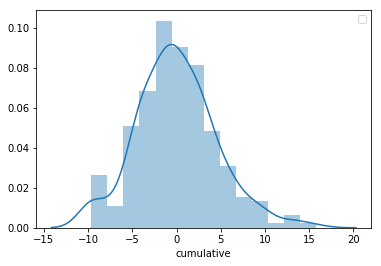

In [119]:
sns.distplot(statsTable.cumulative)
plt.legend()
plt.show()

/Users/codyschank/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
No handles with labels found to put in legend.


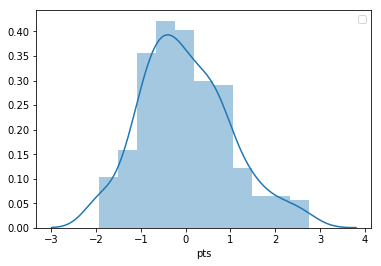

In [127]:
sns.distplot(statsTable.pts)
plt.legend()
plt.show()

/Users/codyschank/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
No handles with labels found to put in legend.


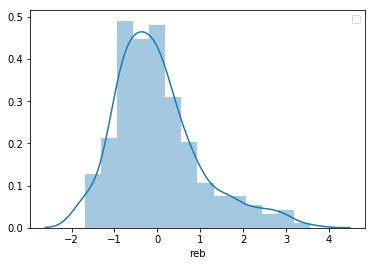

In [120]:
sns.distplot(statsTable.reb)
plt.legend()
plt.show()

/Users/codyschank/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
No handles with labels found to put in legend.


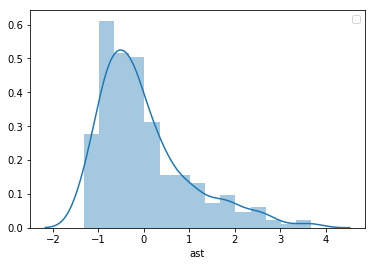

In [121]:
sns.distplot(statsTable.ast)
plt.legend()
plt.show()

/Users/codyschank/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
No handles with labels found to put in legend.


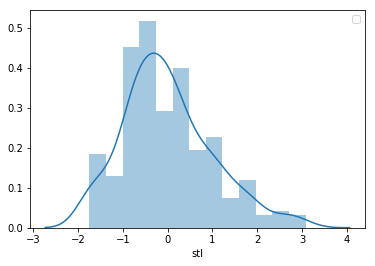

In [122]:
sns.distplot(statsTable.stl)
plt.legend()
plt.show()

/Users/codyschank/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
No handles with labels found to put in legend.


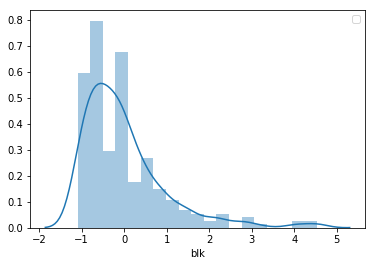

In [123]:
sns.distplot(statsTable.blk)
plt.legend()
plt.show()

/Users/codyschank/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
No handles with labels found to put in legend.


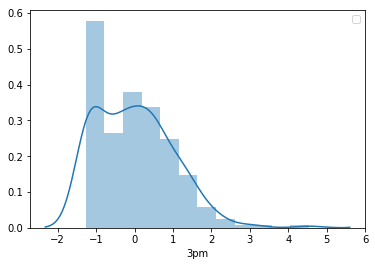

In [124]:
sns.distplot(statsTable['3pm'])
plt.legend()
plt.show()

/Users/codyschank/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
No handles with labels found to put in legend.


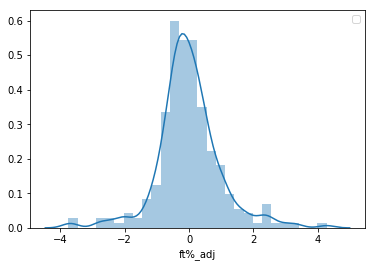

In [125]:
sns.distplot(statsTable['ft%_adj'])
plt.legend()
plt.show()

/Users/codyschank/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
No handles with labels found to put in legend.


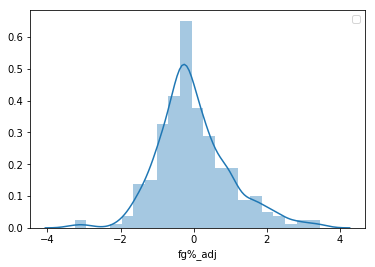

In [126]:
sns.distplot(statsTable['fg%_adj'])
plt.legend()
plt.show()

## Get Roster and Player Schedules for that week (games left in the week)

In [129]:
my_team.player

4           Kevin Durant
6         Damian Lillard
18        Andre Drummond
142       Justin Holiday
86           T.J. Warren
97           Buddy Hield
21     LaMarcus Aldridge
106      Malcolm Brogdon
126    Bogdan Bogdanovic
198       Dewayne Dedmon
171      Al-Farouq Aminu
211          Cody Zeller
173        E'Twaun Moore
107            Kris Dunn
Name: player, dtype: object